In [1]:
import pandas as pd
import numpy as np
from scipy.signal import savgol_filter, gauss_spline, cspline1d, bspline, medfilt, wiener
import cv2
import matplotlib.pyplot as plt

# from IPython.core.interactiveshell import InteractiveShell
# import matplotlib.style as mplstyle
# InteractiveShell.ast_node_interactivity = 'all'
%matplotlib inline

In [2]:
df = pd.read_csv('saved_points.csv', index_col=0)
centred_df = pd.read_csv('saved_points_with_centers.csv', index_col=0)

In [3]:
def get_distance(corner_x, corner_y):
    return np.sqrt((df['center_x']-df[corner_x])**2 + (df['center_y']-df[corner_y])**2)

def apply_savgol(column_name):
    return savgol_filter(df[column_name], 13, 2)

# df['y_top_left'] = apply_savgol('y_top_left')
# df['y_top_right'] = apply_savgol('y_top_right')
# df['y_bot_left'] = apply_savgol('y_bot_left')
# df['y_bot_right'] = apply_savgol('y_bot_right')


df['center_x_1'] = df['x_top_left'] + (df['x_bot_right'] - df['x_top_left'])/2
df['center_y_1'] = df['y_top_left'] + (df['y_bot_right'] - df['y_top_left'])/2
df['center_x_2'] = df['x_top_right'] + (df['x_bot_left'] - df['x_top_right'])/2
df['center_y_2'] = df['y_top_right'] + (df['y_bot_left'] - df['y_top_right'])/2

df['center_x'] = (df['center_x_1'] + df['center_x_2'])/2
df['center_y'] = (df['center_y_1'] + df['center_y_2'])/2

df.drop(columns=['center_x_1', 'center_y_1', 'center_x_2', 'center_y_2'], inplace=True)



df['left_center_width_x'] = (df['x_bot_left'] + df['x_top_left'])/2
df['right_center_width_x'] = (df['x_bot_right'] + df['x_top_right'])/2


# df['left_height'] = np.sqrt((df['x_top_left']-df['x_bot_left'])**2 + (df['y_top_left']-df['y_bot_left'])**2)
# df['top_width'] = np.sqrt((df['x_top_left']-df['x_top_right'])**2 + (df['y_top_left']-df['y_top_right'])**2)
# df['right_height'] = np.sqrt((df['x_top_right']-df['x_bot_right'])**2 + (df['y_top_right']-df['y_bot_right'])**2)
# df['bot_width'] = np.sqrt((df['x_bot_left']-df['x_bot_right'])**2 + (df['y_bot_left']-df['y_bot_right'])**2)

# df['left_height'] = apply_savgol('left_height')
# df['top_width'] = apply_savgol('top_width')
# df['right_height'] = apply_savgol('right_height')
# df['bot_width'] = apply_savgol('bot_width')

df['dist_top_left'] = get_distance('x_top_left', 'y_top_left')
df['dist_bot_left'] = get_distance('x_bot_left', 'y_bot_left')
df['dist_top_right'] = get_distance('x_top_right', 'y_top_right')
df['dist_bot_right'] = get_distance('x_bot_right', 'y_bot_right')

# a = np.array(df[['x_top_right', 'y_top_right']])
# b = np.array(df[['x_bot_left', 'y_bot_left']])

# start_coordinate = np.array(df[['x_top_left', 'y_top_left']])

# a = a-start_coordinate
# b = b-start_coordinate

# df['cos_alpha'] = np.sum(a*b, axis=1)/(np.linalg.norm(a, axis=1)*np.linalg.norm(b, axis=1))
# df['angle'] = np.arccos(df['cos_alpha']) * (180/np.pi)

# df['cos_perspect'] = np.cos(df['angle']/(180/np.pi))

df = df.round(5)



In [4]:
lost_side = []
max_diff = 0
prev_x = df.loc[0]
for i in range(len(df)):
    data = df.loc[i]
    diff = data['dist_top_left']-prev_x['dist_top_left']
    if abs(diff) > 5:
        lost_side.append(i)
    prev_x = data

In [5]:
unstable_left = np.zeros(df.shape[0])
unstable_right = np.zeros_like(unstable_left)


for i in lost_side:
    if abs(df.loc[i, 'x_top_left']-df.loc[i-1, 'x_top_left']) > 8:
        unstable_left[i] = 1
        print('unstable_left', i)
        
    if abs(df.loc[i, 'x_top_right']-df.loc[i-1, 'x_top_right']) > 8:
        print('unstable_right', i)
        unstable_right[i] = 1

unstable_right 55
unstable_right 131
unstable_left 258
unstable_left 426
unstable_right 477


In [6]:
df['unstable_right'] = unstable_right
df['unstable_left'] = unstable_left

In [7]:
for x in range(df.shape[0]):
    row = df.loc[x]
    window = np.arange(x-10, x+10)
    if row['unstable_right']:
        df['x_top_right'] = wiener(df['x_top_right'],18)
        df['x_bot_right'] = wiener(df['x_bot_right'], 18)
        df['y_top_right'] = wiener(df['y_top_right'],18)
        df['y_bot_right'] = wiener(df['y_bot_right'], 18)
    if row['unstable_left']:
        df['x_top_left'] = wiener(df['x_top_left'], 18)
        df['x_bot_left'] = wiener(df['x_bot_left'], 18)
        df['y_top_left'] = wiener(df['y_top_left'], 18)
        df['y_bot_left'] = wiener(df['y_bot_left'], 18)
        
df['y_top_left'] = apply_savgol('y_top_left')
df['y_top_right'] = apply_savgol('y_top_right')
df['y_bot_left'] = apply_savgol('y_bot_left')
df['y_bot_right'] = apply_savgol('y_bot_right')

df['x_top_left'] = apply_savgol('x_top_left')
df['x_top_right'] = apply_savgol('x_top_right')
df['x_bot_left'] = apply_savgol('x_bot_left')
df['x_bot_right'] = apply_savgol('x_bot_right')

In [ ]:
for x in range(df.shape[0]):
    row = df.loc[x]
    window = np.arange(x-30, x+30)
    if row['unstable_right']:
        df.loc[window, 'x_top_right'] = savgol_filter(df.loc[window, 'x_top_right'], 17, 3)
        df.loc[window, 'x_bot_right'] = savgol_filter(df.loc[window, 'x_bot_right'], 17, 3)
    if row['unstable_left']:
        df.loc[window, 'x_top_left'] = savgol_filter(df.loc[window, 'x_top_left'], 17, 3)
        df.loc[window, 'x_bot_left'] = savgol_filter(df.loc[window, 'x_bot_left'], 17, 3)
        
df['dist_top_left'] = get_distance('x_top_left', 'y_top_left')
df['dist_bot_left'] = get_distance('x_bot_left', 'y_bot_left')
df['dist_top_right'] = get_distance('x_top_right', 'y_top_right')
df['dist_bot_right'] = get_distance('x_bot_right', 'y_bot_right')


In [11]:
df.loc[0:220, 'x_top_right']

0      516.750853
1      518.331995
2      519.939364
3      521.572959
4      523.232782
          ...    
216    914.034758
217    920.962850
218    928.061188
219    935.335591
220    942.790316
Name: x_top_right, Length: 221, dtype: float64

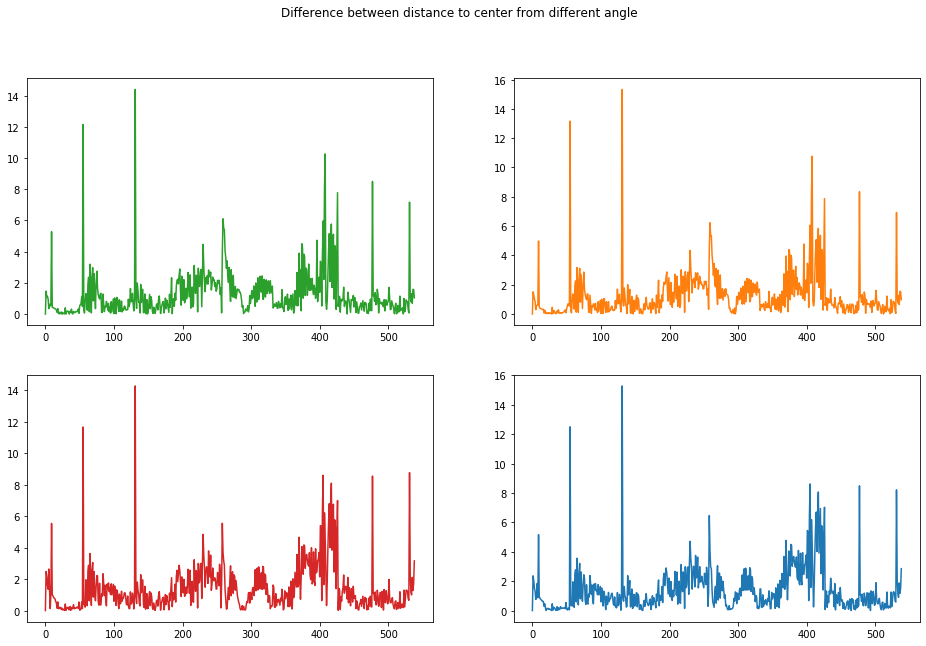

In [24]:
result = []
for x in ['dist_top_left', 'dist_bot_left', 'dist_bot_right', 'dist_top_right']:
    max_diff = 0
    diffs = []
    prev_x = df[x][0]
    for x in df[x]:
        diff = abs(x-prev_x)
        diffs.append(diff)
        if diff > max_diff:
            max_diff = diff
        prev_x = x
    result.append(diffs)
    
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.set_size_inches(16, 10)
width = list(range(539))
fig.suptitle('Difference between distance to center from different angle')
ax1.plot(width, result[0], 'tab:green')
ax2.plot(width, result[1], 'tab:orange')
ax3.plot(width, result[2], 'tab:red')
ax4.plot(width, result[3])

In [11]:
# for i in range(len(df)):
#     data = df.loc[i]
#     if np.any(data[['x_top_right', 'x_bot_right']]>=1276):
#         right_intersection = True
#     elif np.any(data[['x_top_left', 'x_bot_left']]<=4):
#         left_intersection=True
#     else:
#         center=True
    
#     if right_intersection:
#         data['x_top_right'] = 

In [12]:
# df.to_csv('banner_data.csv')

In [25]:
x_df = df[['x_top_left', 'x_top_right', 'x_bot_left', 'x_bot_right']]
y_df = df[['y_top_left', 'y_top_right', 'y_bot_left', 'y_bot_right']]

In [26]:
for i in range(y_df.shape[0]):
    cnt = np.array(list(map(lambda x, y: [x, y], list(x_df.loc[i]),list(y_df.loc[i])))).reshape((-1,1,2)).astype(np.int32)
    img = cv2.imread(f'masks/mask_{i}.jpg')
    cv2.drawContours(img, [cnt], 0, (0,255,0), 1)
    cv2.imwrite(f'contour_images/img_{i}_1.jpg', img)